# Imports

In [1]:
import numpy as np
from scipy import special
from scipy import stats
import scipy
from scipy.ndimage.filters import gaussian_filter1d

# Manuscript code
from seroprevalence import *

# Figures
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from util import *

# Simple SEIR Model

Rather than putting this in one of the codebase files, we put it here so that its assumptions and structure are clear. 

In [2]:
def seir_model_with_soc_dist(initial_conditions, params, t):
    '''
    This function forward integrates a basic SEIR model and returns S,E,I,R arrays.
    
    initial_conditions, a 4-tuple (S0, E0, I0, R0) with initial counts in compartments
    params, a 4-tuple (alpha,beta,gamma,rho) with parameters:
        alpha, E->I symptom onset rate
        beta, infection rate per S-I contact
        gamma, I->R recovery rate
        rho, the fraction of contacts that remain after social distancing.
    t, an array of timepoints, ASSUMED TO BE EQUALLY SPACED. 
    
    Returns a numpy array of S, E, I, and R arrays. 
    '''
    S0, E0, I0, R0 = initial_conditions
    S, E, I, R = [S0], [E0], [I0], [R0]
    alpha, beta, gamma, rho = params
    dt = t[1] - t[0]
    for _ in t[1:]:
        St = S[-1] - (rho*beta*S[-1]*I[-1])*dt
        Et = E[-1] + (rho*beta*S[-1]*I[-1] - alpha*E[-1])*dt
        It = I[-1] + (alpha*E[-1] - gamma*I[-1])*dt
        Rt = R[-1] + (gamma*I[-1])*dt
        S.append(St)
        E.append(Et)
        I.append(It)
        R.append(Rt)
    return np.stack([S, E, I, R]).T

## Serological Test Kit Parameters

Adjust as needed. We start with [sensingself.me/covid.php](sensingself.me/covid.php) IgG parameters of sensitivity 0.93 and specificity 0.975.  

In [3]:
sensitivity = 0.93
specificity = 0.975
# for convenience, swap to false positive fp and false negative fn.
fp = 1-specificity
fn = 1-sensitivity

## SEIR Model Parameters

In [4]:
# Timesteps
N=10000
t_max = 150
dt = 0.1
t = np.linspace(0, t_max, int(t_max/dt) + 1)
# SEIR Dynamics
alpha = 0.2
beta = 1.75
gamma = 0.5
# Consider two scenarios. 
# 1. "Light" social distancing, with 25% reduction in contacts
sd_light = 0.75
params_light = alpha, beta, gamma, sd_light
# 2. "Heavy" social distancing, with 50% reduction in contacts
sd_heavy = 0.5
params_heavy = alpha, beta, gamma, sd_heavy

# Hypothetical Serology Simulation

In [5]:
# Choose a seropositivity rate
p = 0.2
# Choose a number of samples to simulation
n = 500
# Draw samples
pos = simulate_serology([p],[n],sensitivity=sensitivity,specificity=specificity)[0]
neg = n - pos

# Perform inference: draw from seroprevalence posterior

In [6]:
# Number of Monte Carlo Samples
n_mc_samples = 10000
seroprevalence_samples = sample_post_r_log(pos,neg,fp,fn,size=n_mc_samples)

# SEIR simulations using draws from seroprevalence

In [7]:
# Generate SEIR curves from seroprevalence samples
n_SEIR_curves = 100
results_light = []
results_heavy = []
for idx in range(n_SEIR_curves):
    # Initial conditions
    init_vals = 1-10/N-10/N-seroprevalence_samples[idx], 10/N, 10/N, seroprevalence_samples[idx]
    results_light.append(seir_model_with_soc_dist(init_vals, params_light, t))
    results_heavy.append(seir_model_with_soc_dist(init_vals, params_heavy, t))

From our simulations, let's get peak timing and heights:

In [8]:
# peak heights
maxs_heavy = [np.max(results_heavy[i][:,2]) for i in range(n_SEIR_curves)]
maxs_light = [np.max(results_light[i][:,2]) for i in range(n_SEIR_curves)]
# peak timings
tmaxs_heavy = [t[np.argmax(results_heavy[i][:,2])] for i in range(n_SEIR_curves)]
tmaxs_light = [t[np.argmax(results_light[i][:,2])]for i in range(n_SEIR_curves)]

# Plot Results

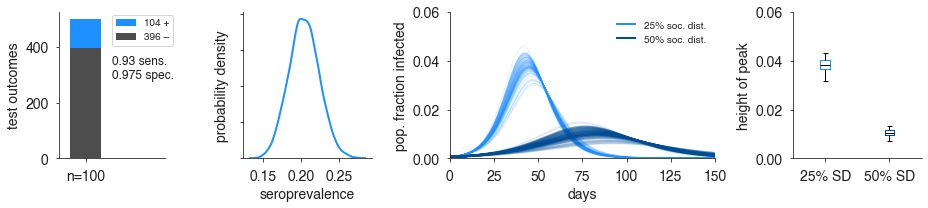

In [9]:
# Important stuff first: colors
dark_grey = [.3,.3,.3]
colors = ['dodgerblue']
bin_width=0.6
lw=2
alph = 0.12

# Set up some axes
fig, axs = plt.subplots(nrows=1, ncols=4, 
                        figsize=(13,3),
                        gridspec_kw={'width_ratios': [1.4, 1.7, 3.5, 1.7]})

#1. Plot serological sampling outcomes
ax = axs[0]
ax.bar('n=100',pos, bin_width,
       color=colors[0],
       bottom=neg,
       label='{} +'.format(pos))
ax.bar('n=100',neg, bin_width,
      color=dark_grey,
       label='{} –'.format(neg))
ax.set_xlim([-0.5,1.5])
ax.set_ylim(bottom=0)
ax.legend(loc=[0.5,0.77])
ax.text(0.5,0.55,'{} sens.\n{} spec.'.format(sensitivity,specificity),
        fontsize=12,
        transform=ax.transAxes)
ax.set_ylabel('test outcomes')

#2. Plot seroprevalence posterior
ax = axs[1]
counts, bins = np.histogram(seroprevalence_samples,
                            bins=100,
                            density=True,)
midpoints = (bins[:-1]+bins[1:])/2
smooth_counts = gaussian_filter1d(counts, 2)
ax.plot(midpoints,smooth_counts,
        color=colors[0],
       lw=lw,
       label='n={}'.format(n))
ax.set_xlabel('seroprevalence')
ax.set_ylabel('probability density')
ax.set_yticklabels([])
ax.set_ylim(bottom=0)

#3. Plot simulation curves
ax = axs[2]
for res in results_light:
    ax.plot(t,res[:,2],color=colors[0],lw=lw/2,alpha=alph)
for res in results_heavy:
    ax.plot(t,res[:,2],color=lighten_color(colors[0],1.6),lw=lw,alpha=alph)
ax.set_xlabel('days')
ax.set_ylabel('pop. fraction infected')
ax.set_ylim(bottom=0)
ax.set_xlim([0,t_max])
ax.set_ylim([0,0.06])
legend_bits = [
    Line2D([0], [0], color=colors[0], lw=2, 
           label='{}% soc. dist.'.format(int(100*(1-sd_light)))),
    Line2D([0], [0], color=lighten_color(colors[0],1.6), lw=2, 
           label='{}% soc. dist.'.format(int(100*(1-sd_heavy)))),
]
ax.legend(handles=legend_bits,loc='upper right',frameon=False)

# 4. Plot the distribution of peak heights
ax = axs[3]
q = ax.boxplot([maxs_light,maxs_heavy],
               showfliers=False)
colz = [colors[0],lighten_color(colors[0],1.6)]
for i in range(2):
    for x in ['boxes']:
        q[x][i].set_color(colz[i])
    for x in ['medians']:
        q[x][i].set_color('black')
    
ax.set_xticks([1,2])
ax.set_xticklabels(['{}% SD'.format(int(100*(1-sd_light))),
                    '{}% SD'.format(int(100*(1-sd_heavy)))])
ax.set_ylabel('height of peak')
ax.set_ylim(axs[2].get_ylim())

[finalize(ax, ignoreLegend=True) for ax in axs.flatten()]
plt.tight_layout()